In [ ]:
import datetime
import gc
import random
import time

import numpy
import pandas
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
import IPython.display as disp

class Progress:
    """Wrapper for IPython.display.ProgressBar with improved performance"""

    def __init__(self, total):
        self.bar = disp.ProgressBar(total)
        self.total = total
        self.progress = 0
        self.last = 0
        self.start = time.monotonic_ns()
    def inc(self, delta=1):
        self.progress += delta
        if time.monotonic_ns() - self.last > 1e8:
            self.bar.progress = self.progress
            self.bar.update()
            self.last = time.monotonic_ns()
    def __enter__(self):
        return self
    def __exit__(self, exc_type, exc_value, tb):
        self.bar.progress = self.progress
        self.bar.update()
        print(f"Completed {self.progress}/{self.total} in {(time.monotonic_ns() - self.start) / 1000000}ms")
        return False

class Timer:
    def __init__(self, name):
        self.name = name
    
    def __enter__(self):
        self.start = time.monotonic_ns()
        print(f"Task: {self.name}")

    def __exit__(self, exc_type, exc_value, tb):
        end = time.monotonic_ns()
        time_ns = end - self.start
        print(f"Took {time_ns / 1000000}ms")
        return False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!test -d dataset || unzip /content/drive/Shareddrives/'STAT4609 Netflix'/dataset.zip -d dataset

Archive:  /content/drive/Shareddrives/STAT4609 Netflix/dataset.zip
  inflating: dataset/README          
  inflating: dataset/combined_data_1.txt  
  inflating: dataset/combined_data_2.txt  
  inflating: dataset/combined_data_3.txt  
  inflating: dataset/combined_data_4.txt  
  inflating: dataset/movie_titles.csv  
  inflating: dataset/probe.txt       
  inflating: dataset/qualifying.txt  


In [ ]:
!cp /content/drive/Shareddrives/'STAT4609 Netflix'/preprocess-dataset /usr/local/bin
!chmod +x /usr/local/bin/preprocess-dataset
!test -f dataset/output.npy || (cd dataset && preprocess-dataset)

Read 1000000 lines of probe
Read 1000000 lines
Read 2000000 lines
Read 3000000 lines
Read 4000000 lines
Read 5000000 lines
Read 6000000 lines
Read 7000000 lines
Read 8000000 lines
Read 9000000 lines
Read 10000000 lines
Read 11000000 lines
Read 12000000 lines
Read 13000000 lines
Read 14000000 lines
Read 15000000 lines
Read 16000000 lines
Read 17000000 lines
Read 18000000 lines
Read 19000000 lines
Read 20000000 lines
Read 21000000 lines
Read 22000000 lines
Read 23000000 lines
Read 24000000 lines
Empty line!
Read 25000000 lines
Read 26000000 lines
Read 27000000 lines
Read 28000000 lines
Read 29000000 lines
Read 30000000 lines
Read 31000000 lines
Read 32000000 lines
Read 33000000 lines
tcmalloc: large alloc 1879048192 bytes == 0x5630aae9c000 @  0x7fe83163a2a4 0x56303750c120 0x56303750c265 0x56303750af2a 0x5630375095de 0x56303750b956 0x56303750b96c 0x56303752630a 0x56303750b855 0x7fe830bfbbf7 0x563037507e3e
Read 34000000 lines
Read 35000000 lines
Read 36000000 lines
Read 37000000 lines
Read

In [ ]:
COL_USER = 0
COL_MOVIE = 1
COL_RATINGS = 2
COL_YEAR = 3
COL_DOY = 4
COL_DOW = 5
COL_PROBED = 6

with Timer("Loading data..."):
    data = numpy.load("dataset/output.npy")
    data_size = data.shape[0]

with Timer("Counting users and movies"):
    user_count = numpy.max(data[:, COL_USER]) + 1
    movie_count = numpy.max(data[:, COL_MOVIE]) + 1

with Timer("Copying train/test split"):
    train = data[data[:, 6] == 0, :3].copy()
    evaluation = data[data[:, 6] == 1, :3].copy()

# Free the memory used to hold the whole dataset
del data
gc.collect()

print(f"Train/test size: {train.shape[0]}/{evaluation.shape[0]}")

evaluation_results = []

Task: Loading data...
Took 4088.67364ms
Task: Counting users and movies
Took 559.444552ms
Task: Copying train/test split
Took 4882.736761ms
Train/test size: 99072112/1408395


In [ ]:
class KnnRecommend:
    def __init__(self, metric, aggregate, k, q, batch_size=1024):
        """Arguments:
        metric: a function taking a size n vector and a size q*n matrix, returning the distances of the vector to each of the q rows
        aggregate: a function that takes in a vector of ratings and weights and aggregates them to a single rating
        k: the number of neighbours to use, k <= q
        q: the number of users to select neighbours from
        batch_size: number of rows to process in each batch; does not affect results"""
        self.metric = metric
        self.aggregate = aggregate
        self.k = k
        self.q = q
        self.batch_size = batch_size
    def fit(self, ratings):
        raise Exception("Uninitialized function")
    def predict_rating(self, user_id, movie_id):
        raise Exception("Uninitialized function")
    def evaluate(self):
        raise Exception("Uninitialized function")

In [ ]:
class DataLoader:
    def __init__(self, csr, q):
        self.csr = csr.astype(numpy.float64)
        self.ptr = 0

        self._output = numpy.empty((csr.shape[0], q))

    def set_batch_size(self, batch_size):
        self.batch_size = batch_size
        self.buf = numpy.empty((batch_size, self.csr.shape[1]))

    def __iter__(self):
        return self
    def __next__(self):
        end = min(self.ptr + self.batch_size, self.csr.shape[0])
        num_rows = end - self.ptr
        self.last_start = self.ptr
        self.last_end = end
        if num_rows == 0:
            raise StopIteration
        self.csr[self.ptr:end, :].toarray(out=self.buf[:num_rows, :])
        self.buf[self.buf == 0] = numpy.nan
        self.ptr = end
        return self.buf[:num_rows, :]

    def output(self, vec):
        self._output[self.last_start:self.last_end] = vec

    def get_output(self):
        return self._output

In [ ]:
def _fit(self, ratings):
    gc.collect()

    # express as a sparse matrix such that coo[user, movie] = rating
    with Timer("Counting users and movies"):
        user_count = ratings[:, COL_USER].max() + 1
        movie_count = ratings[:, COL_MOVIE].max() + 1
    
    with Timer("Repacking ratings to COO format"):
        ratings_col = ratings[:, COL_RATINGS].astype(numpy.float64)
        user_col = ratings[:, COL_USER]
        movie_col = ratings[:, COL_MOVIE]
        coo = scipy.sparse.coo_matrix((ratings_col, (user_col, movie_col)), shape=(user_count, movie_count))
    with Timer("Repacking ratings to CSR format"):
        ratings = coo.tocsr()
        
    with Timer("Choosing top Q users"):
        user_rating_counts = numpy.asarray((ratings != 0).sum(axis=1)).reshape(-1)
        top_q_users = numpy.argsort(-user_rating_counts)[:self.q]
        
    with Timer("Computing movie mean ratings"):
        movie_rating_counts = numpy.asarray((ratings != 0).sum(axis=0)).reshape(-1)
        movie_means = numpy.asarray(ratings.sum(axis=0) / movie_rating_counts).reshape(-1)

    with Timer("Extracting top q ratings"):
        top_q_ratings = ratings[top_q_users, :].toarray().astype(numpy.float64)
        top_q_ratings[top_q_ratings == 0] = numpy.nan
    with Timer("Computing distance matrix"):
        with Progress(user_count) as progress:
            loader = DataLoader(ratings, self.q)
            loader.set_batch_size(self.batch_size)
            self.metric(loader, top_q_ratings, movie_means, progress)
        distmat = loader.get_output()

    with Timer("Sorting distances"):
        neighbours = numpy.argsort(distmat, axis=1)

    self.distmat = distmat # m * q (float)
    self.neighbours = neighbours # m * q (int 0..q)
    self.top_q_users = top_q_users # q (int 0..m)
    self.top_q_ratings = top_q_ratings # q * n (float)
    self.movie_means = movie_means # n (float)

KnnRecommend.fit = _fit

In [ ]:
def _predict(self, um):
    """um is an n*2 matrix.
    The first column is the user ID.
    The second column is the movie ID.
    Returns a size n vector of predicted ratings."""

    def imp(model, um):
        probes = um.shape[0]
        users = um[:, 0]
        movies = um[:, 1]
    
        # neighbour_cols[i, j] is the user ID of the jth neighbour of the ith probed user
        neighbour_cols = model.neighbours[users, :model.k]
        # neighbour_indices[i, j] is the index of the distance of the jth neighbour of the ith probed user in distmat
        neighbour_indices = neighbour_cols + numpy.arange(probes).reshape((-1, 1)) * model.distmat.shape[1]
        # distances[i, j] is the distance between the ith probed user and his jth neighbour
        distances = model.distmat[users, :].take(neighbour_indices)
        # neighbour_ratings[i, j] is the rating on the ith probed movie by the jth neighbour of the ith probed user
        neighbour_ratings = model.top_q_ratings[neighbour_cols.transpose(), movies].transpose()
        return model.aggregate(neighbour_ratings, distances, model.movie_means[movies])

    output = numpy.empty(um.shape[0])
    ptr = 0
    nan_count = 0
    with Progress(um.shape[0]) as progress:
        while ptr < um.shape[0]:
            end = min(ptr + self.batch_size, um.shape[0])
            batch_output, nan_count_comp = imp(self, um[ptr:end, :])
            output[ptr:end] = batch_output
            progress.inc(delta=end - ptr)
            ptr = end
            nan_count += nan_count_comp

    if nan_count > 0:
        print(f"{nan_count} entries have no non-NAN neighbours")

    return output

KnnRecommend.predict = _predict

In [ ]:
def _evaluate(self):
    gc.collect()
    self.fit(train)
    pred = self.predict(evaluation[:, [COL_USER, COL_MOVIE]])
    target = evaluation[:, COL_RATINGS]
    rmse = numpy.sqrt(((pred - target) ** 2).mean())
    evaluation_results.append((self.aggregate, self.metric, self.k, self.q, rmse))
    return rmse

KnnRecommend.evaluate = _evaluate

In [ ]:
class Metric:
    """For all methods, loader is DataLoader instance, mat is a q*n rating matrix,
    means is a size n vector of mean ratings,
    and output is a function to assign results to."""

    def p_norm(p):
        def impl(loader, mat, means, progress, p):
            q, n = mat.shape
            mat_1qn = mat.reshape((1, q, n))
    
            delta_buf = numpy.empty((loader.batch_size, q, n))
            norm_buf = numpy.empty((loader.batch_size, q))
            for batch in loader:
                b = batch.shape[0] # usually this is loader.batch_size, but this is smaller in the last batch
                batch = batch.reshape((b, 1, n))

                delta = delta_buf[:b, :, :]
                numpy.subtract(mat_1qn, batch, out=delta)
                numpy.abs(delta, out=delta)
                numpy.power(delta, p, out=delta)

                norm = norm_buf[:b, :]
                numpy.sum(delta, axis=2, out=norm)
                
                loader.output(norm)

        return lambda loader, mat, means, progress: impl(loader, mat, means, progress, p)

    def cosine_mean(loader, mat, means, progress):
        q = mat.shape[0]

        ret = numpy.empty(q)
        mat = mat - means.reshape((1, -1))
        nan_indices = numpy.where(numpy.isnan(mat))
        mat[nan_indices] = numpy.take(means, nan_indices[1]) # assume average if rating is unknown
        norm_mat = numpy.linalg.norm(mat, axis=1)
        mat_nq = mat.transpose()

        # preallocate `inner` to improve performance
        inner_buf = numpy.empty((loader.batch_size, q))

        nan_bools_buf = numpy.empty((loader.batch_size, mat.shape[1]), dtype=bool)

        for batch in loader:
            b = batch.shape[0]
            inner = inner_buf[:b, :]
            batch -= means.reshape((1, -1))

            nan_bools = nan_bools_buf[:b, :]
            # numpy.isnan(batch, out=nan_bools)
            # batch[nan_bools] = 0 # impute with means
            numpy.matmul(batch, mat_nq, out=inner)
            norm_batch = numpy.linalg.norm(batch, axis=1)
            inner /= norm_batch.reshape((-1, 1))
            inner /= norm_mat.reshape((1, -1))
            loader.output(inner)
            progress.inc(delta=b)

        return ret

In [ ]:
class Aggregate:
    """For all methods, ratings is a p*q rating matrix,
    distances is a p*q distance matrix,
    means is a size-p mean rating vector"""

    def baseline(ratings, distances, means):
        return means, 0

    def average(ratings, distances, means):
        ret = numpy.nanmean(ratings, axis=1)
        nan_indices = numpy.isnan(ret)

        nan_count = nan_indices.sum()
        ret[nan_indices] = means[nan_indices]
        return ret, nan_count

## Example shown for Q = 300 and Q = 400


In [ ]:
rmse_q300 = []
for k in [10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,300]:
  model = KnnRecommend(Metric.cosine_mean, Aggregate.average, k, 300,batch_size =526)
  rmse = model.evaluate()
  rmse_q300.append(rmse)

Task: Counting users and movies
Took 276.023694ms
Task: Repacking ratings to COO format
Took 714.3765ms
Task: Repacking ratings to CSR format
Took 8424.450239ms
Task: Choosing top Q users
Took 533.711151ms
Task: Computing movie mean ratings
Took 701.117918ms
Task: Extracting top q ratings
Took 65.876651ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 239088.519688ms
Took 239090.93952ms
Task: Sorting distances
Took 3378.089287ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 1992.310285ms
1369 entries have no non-NAN neighbours
Task: Counting users and movies
Took 274.674332ms
Task: Repacking ratings to COO format
Took 739.419266ms
Task: Repacking ratings to CSR format
Took 8882.902059ms
Task: Choosing top Q users
Took 596.395646ms
Task: Computing movie mean ratings
Took 710.750682ms
Task: Extracting top q ratings
Took 65.100866ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 238027.814165ms
Took 238030.105586ms
Task: Sorting distances
Took 1580.675373ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 2471.966497ms
1052 entries have no non-NAN neighbours
Task: Counting users and movies
Took 279.603861ms
Task: Repacking ratings to COO format
Took 760.85129ms
Task: Repacking ratings to CSR format
Took 9093.237716ms
Task: Choosing top Q users
Took 550.453627ms
Task: Computing movie mean ratings
Took 724.088026ms
Task: Extracting top q ratings
Took 66.45548ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 238018.378207ms
Took 238020.24798ms
Task: Sorting distances
Took 1572.174158ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 3041.166339ms
866 entries have no non-NAN neighbours
Task: Counting users and movies
Took 279.109596ms
Task: Repacking ratings to COO format
Took 748.369871ms
Task: Repacking ratings to CSR format
Took 8870.960166ms
Task: Choosing top Q users
Took 543.486121ms
Task: Computing movie mean ratings
Took 716.452806ms
Task: Extracting top q ratings
Took 65.759934ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 238567.145959ms
Took 238568.183806ms
Task: Sorting distances
Took 1600.187497ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 4144.291337ms
471 entries have no non-NAN neighbours
Task: Counting users and movies
Took 280.39139ms
Task: Repacking ratings to COO format
Took 744.947874ms
Task: Repacking ratings to CSR format
Took 8808.170153ms
Task: Choosing top Q users
Took 541.981065ms
Task: Computing movie mean ratings
Took 716.411635ms
Task: Extracting top q ratings
Took 66.743062ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 237774.477696ms
Took 237775.456724ms
Task: Sorting distances
Took 1562.260614ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 4725.46253ms
414 entries have no non-NAN neighbours
Task: Counting users and movies
Took 269.792631ms
Task: Repacking ratings to COO format
Took 742.210392ms
Task: Repacking ratings to CSR format
Took 8520.023948ms
Task: Choosing top Q users
Took 549.585753ms
Task: Computing movie mean ratings
Took 703.954522ms
Task: Extracting top q ratings
Took 66.937389ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 237359.129269ms
Took 237361.116298ms
Task: Sorting distances
Took 1574.286577ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 5542.466828ms
356 entries have no non-NAN neighbours
Task: Counting users and movies
Took 276.857853ms
Task: Repacking ratings to COO format
Took 770.109596ms
Task: Repacking ratings to CSR format
Took 8565.64533ms
Task: Choosing top Q users
Took 530.670458ms
Task: Computing movie mean ratings
Took 713.262141ms
Task: Extracting top q ratings
Took 67.252546ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 237381.852639ms
Took 237381.975641ms
Task: Sorting distances
Took 1569.043753ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 6075.290122ms
350 entries have no non-NAN neighbours
Task: Counting users and movies
Took 276.461318ms
Task: Repacking ratings to COO format
Took 743.079786ms
Task: Repacking ratings to CSR format
Took 8446.614328ms
Task: Choosing top Q users
Took 537.490373ms
Task: Computing movie mean ratings
Took 720.019797ms
Task: Extracting top q ratings
Took 65.685736ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 238057.722183ms
Took 238060.18627ms
Task: Sorting distances
Took 1560.957558ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 6866.925321ms
350 entries have no non-NAN neighbours
Task: Counting users and movies
Took 274.292059ms
Task: Repacking ratings to COO format
Took 756.517903ms
Task: Repacking ratings to CSR format
Took 8723.18483ms
Task: Choosing top Q users
Took 540.982359ms
Task: Computing movie mean ratings
Took 710.408292ms
Task: Extracting top q ratings
Took 66.505202ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 238154.641533ms
Took 238156.729053ms
Task: Sorting distances
Took 1567.968459ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 7634.384489ms
332 entries have no non-NAN neighbours
Task: Counting users and movies
Took 267.123944ms
Task: Repacking ratings to COO format
Took 731.219532ms
Task: Repacking ratings to CSR format
Took 8673.124451ms
Task: Choosing top Q users
Took 535.105221ms
Task: Computing movie mean ratings
Took 709.174337ms
Task: Extracting top q ratings
Took 64.621497ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 237482.669683ms
Took 237484.030533ms
Task: Sorting distances
Took 1590.266453ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 8188.230135ms
324 entries have no non-NAN neighbours
Task: Counting users and movies
Took 266.79213ms
Task: Repacking ratings to COO format
Took 728.882041ms
Task: Repacking ratings to CSR format
Took 8373.977728ms
Task: Choosing top Q users
Took 539.046001ms
Task: Computing movie mean ratings
Took 718.99193ms
Task: Extracting top q ratings
Took 66.077856ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 237770.672933ms
Took 237773.975989ms
Task: Sorting distances
Took 1568.24635ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 8960.509803ms
52 entries have no non-NAN neighbours
Task: Counting users and movies
Took 265.742069ms
Task: Repacking ratings to COO format
Took 722.412235ms
Task: Repacking ratings to CSR format
Took 8566.648159ms
Task: Choosing top Q users
Took 556.636223ms
Task: Computing movie mean ratings
Took 705.420555ms
Task: Extracting top q ratings
Took 67.110479ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 236865.165182ms
Took 236866.925449ms
Task: Sorting distances
Took 1560.467024ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 9336.350209ms
34 entries have no non-NAN neighbours
Task: Counting users and movies
Took 256.071208ms
Task: Repacking ratings to COO format
Took 701.513633ms
Task: Repacking ratings to CSR format
Took 7715.063419ms
Task: Choosing top Q users
Took 536.952158ms
Task: Computing movie mean ratings
Took 705.515906ms
Task: Extracting top q ratings
Took 65.899527ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 236541.141306ms
Took 236542.21343ms
Task: Sorting distances
Took 1568.474551ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 10154.207587ms
24 entries have no non-NAN neighbours
Task: Counting users and movies
Took 262.300701ms
Task: Repacking ratings to COO format
Took 699.102817ms
Task: Repacking ratings to CSR format
Took 7632.302605ms
Task: Choosing top Q users
Took 532.621114ms
Task: Computing movie mean ratings
Took 709.101319ms
Task: Extracting top q ratings
Took 60.933488ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 237165.03291ms
Took 237166.103083ms
Task: Sorting distances
Took 1586.652131ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 10896.024262ms
9 entries have no non-NAN neighbours
Task: Counting users and movies
Took 267.31508ms
Task: Repacking ratings to COO format
Took 706.152674ms
Task: Repacking ratings to CSR format
Took 7758.858674ms
Task: Choosing top Q users
Took 531.193361ms
Task: Computing movie mean ratings
Took 700.772246ms
Task: Extracting top q ratings
Took 61.221463ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 237975.419558ms
Took 237977.296389ms
Task: Sorting distances
Took 1615.982224ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 11641.091158ms
9 entries have no non-NAN neighbours
Task: Counting users and movies
Took 262.463098ms
Task: Repacking ratings to COO format
Took 717.365105ms
Task: Repacking ratings to CSR format
Took 7609.214961ms
Task: Choosing top Q users
Took 521.359131ms
Task: Computing movie mean ratings
Took 701.365405ms
Task: Extracting top q ratings
Took 60.292389ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 237609.41721ms
Took 237611.263106ms
Task: Sorting distances
Took 1589.904842ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 12171.862571ms
9 entries have no non-NAN neighbours


In [ ]:
print(rmse_q300)

[1.404534079770204, 1.2823973117635439, 1.247372393289325, 1.1959231786321178, 1.189881280446423, 1.177705262948518, 1.167758882780713, 1.1527838530728955, 1.1542050113909228, 1.1678293427312367, 1.1662597354720212, 1.1769096906557126, 1.174123219198517, 1.1700075927386806, 1.1690441575089083, 1.1702632616032251]


In [ ]:
rmse_q400 = []
for k in [10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,310,330,350,370,390,400]:
  model = KnnRecommend(Metric.cosine_mean, Aggregate.average, k, 400,batch_size =526)
  rmse = model.evaluate()
  rmse_q400.append(rmse)

Task: Counting users and movies
Took 273.149515ms
Task: Repacking ratings to COO format
Took 721.143697ms
Task: Repacking ratings to CSR format
Took 7605.584206ms
Task: Choosing top Q users
Took 525.747403ms
Task: Computing movie mean ratings
Took 698.391994ms
Task: Extracting top q ratings
Took 76.280479ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 280892.644212ms
Took 280895.045712ms
Task: Sorting distances
Took 5333.522666ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 2200.847533ms
1069 entries have no non-NAN neighbours
Task: Counting users and movies
Took 267.746819ms
Task: Repacking ratings to COO format
Took 697.627259ms
Task: Repacking ratings to CSR format
Took 10730.049613ms
Task: Choosing top Q users
Took 525.61927ms
Task: Computing movie mean ratings
Took 692.508772ms
Task: Extracting top q ratings
Took 74.972774ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 282234.582873ms
Took 282236.48945ms
Task: Sorting distances
Took 2123.522908ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 2732.998698ms
832 entries have no non-NAN neighbours
Task: Counting users and movies
Took 272.916481ms
Task: Repacking ratings to COO format
Took 712.086971ms
Task: Repacking ratings to CSR format
Took 10701.492281ms
Task: Choosing top Q users
Took 520.730503ms
Task: Computing movie mean ratings
Took 689.698466ms
Task: Extracting top q ratings
Took 74.478016ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 281518.650701ms
Took 281520.052468ms
Task: Sorting distances
Took 2113.100834ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 3244.120142ms
766 entries have no non-NAN neighbours
Task: Counting users and movies
Took 265.934397ms
Task: Repacking ratings to COO format
Took 709.420637ms
Task: Repacking ratings to CSR format
Took 10487.124204ms
Task: Choosing top Q users
Took 530.163435ms
Task: Computing movie mean ratings
Took 703.991604ms
Task: Extracting top q ratings
Took 72.914309ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 281700.822981ms
Took 281701.897936ms
Task: Sorting distances
Took 2122.766144ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 4227.77901ms
733 entries have no non-NAN neighbours
Task: Counting users and movies
Took 266.49487ms
Task: Repacking ratings to COO format
Took 710.753465ms
Task: Repacking ratings to CSR format
Took 10531.241032ms
Task: Choosing top Q users
Took 529.528308ms
Task: Computing movie mean ratings
Took 703.859976ms
Task: Extracting top q ratings
Took 73.107876ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 282306.263562ms
Took 282307.433701ms
Task: Sorting distances
Took 2121.730931ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 5000.516656ms
710 entries have no non-NAN neighbours
Task: Counting users and movies
Took 270.290884ms
Task: Repacking ratings to COO format
Took 729.648097ms
Task: Repacking ratings to CSR format
Took 10961.285141ms
Task: Choosing top Q users
Took 525.632142ms
Task: Computing movie mean ratings
Took 704.131155ms
Task: Extracting top q ratings
Took 76.54071ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 283531.452366ms
Took 283533.239042ms
Task: Sorting distances
Took 2135.040972ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 5575.553601ms
694 entries have no non-NAN neighbours
Task: Counting users and movies
Took 264.840199ms
Task: Repacking ratings to COO format
Took 705.291749ms
Task: Repacking ratings to CSR format
Took 10377.368373ms
Task: Choosing top Q users
Took 524.760418ms
Task: Computing movie mean ratings
Took 704.653678ms
Task: Extracting top q ratings
Took 72.783198ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 281608.242935ms
Took 281609.276885ms
Task: Sorting distances
Took 2118.981518ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 6324.500799ms
586 entries have no non-NAN neighbours
Task: Counting users and movies
Took 269.415363ms
Task: Repacking ratings to COO format
Took 711.163524ms
Task: Repacking ratings to CSR format
Took 10360.420965ms
Task: Choosing top Q users
Took 536.820907ms
Task: Computing movie mean ratings
Took 700.611996ms
Task: Extracting top q ratings
Took 73.02666ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 281946.935219ms
Took 281948.038218ms
Task: Sorting distances
Took 2130.690763ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 6990.912359ms
573 entries have no non-NAN neighbours
Task: Counting users and movies
Took 276.007563ms
Task: Repacking ratings to COO format
Took 708.851493ms
Task: Repacking ratings to CSR format
Took 11417.213592ms
Task: Choosing top Q users
Took 521.284723ms
Task: Computing movie mean ratings
Took 693.737455ms
Task: Extracting top q ratings
Took 75.409715ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 282376.033714ms
Took 282376.889229ms
Task: Sorting distances
Took 2108.971388ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 7625.808582ms
520 entries have no non-NAN neighbours
Task: Counting users and movies
Took 414.51041ms
Task: Repacking ratings to COO format
Took 699.233712ms
Task: Repacking ratings to CSR format
Took 10708.205897ms
Task: Choosing top Q users
Took 527.920905ms
Task: Computing movie mean ratings
Took 698.397809ms
Task: Extracting top q ratings
Took 72.18866ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 282243.984913ms
Took 282245.144449ms
Task: Sorting distances
Took 2113.568067ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 8236.813105ms
503 entries have no non-NAN neighbours
Task: Counting users and movies
Took 267.469217ms
Task: Repacking ratings to COO format
Took 706.301728ms
Task: Repacking ratings to CSR format
Took 10697.122042ms
Task: Choosing top Q users
Took 527.177725ms
Task: Computing movie mean ratings
Took 695.034615ms
Task: Extracting top q ratings
Took 73.374249ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 282262.587919ms
Took 282263.715854ms
Task: Sorting distances
Took 2098.278563ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 9057.918141ms
474 entries have no non-NAN neighbours
Task: Counting users and movies
Took 270.553269ms
Task: Repacking ratings to COO format
Took 713.013154ms
Task: Repacking ratings to CSR format
Took 10666.973531ms
Task: Choosing top Q users
Took 529.051941ms
Task: Computing movie mean ratings
Took 701.415367ms
Task: Extracting top q ratings
Took 72.937834ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 283637.420389ms
Took 283639.543745ms
Task: Sorting distances
Took 2113.109704ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 9689.588528ms
446 entries have no non-NAN neighbours
Task: Counting users and movies
Took 393.243503ms
Task: Repacking ratings to COO format
Took 715.14173ms
Task: Repacking ratings to CSR format
Took 12868.196687ms
Task: Choosing top Q users
Took 530.899682ms
Task: Computing movie mean ratings
Took 694.890764ms
Task: Extracting top q ratings
Took 72.766373ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 283728.67979ms
Took 283729.718253ms
Task: Sorting distances
Took 2119.23184ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 10519.260744ms
388 entries have no non-NAN neighbours
Task: Counting users and movies
Took 271.535165ms
Task: Repacking ratings to COO format
Took 706.901541ms
Task: Repacking ratings to CSR format
Took 12262.325905ms
Task: Choosing top Q users
Took 522.409295ms
Task: Computing movie mean ratings
Took 709.03265ms
Task: Extracting top q ratings
Took 71.763392ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 283524.854132ms
Took 283526.149105ms
Task: Sorting distances
Took 2119.3062ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 11013.889205ms
68 entries have no non-NAN neighbours
Task: Counting users and movies
Took 270.276015ms
Task: Repacking ratings to COO format
Took 699.210642ms
Task: Repacking ratings to CSR format
Took 11756.845545ms
Task: Choosing top Q users
Took 526.888823ms
Task: Computing movie mean ratings
Took 704.260772ms
Task: Extracting top q ratings
Took 74.085271ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 282772.407776ms
Took 282774.535168ms
Task: Sorting distances
Took 2120.812012ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 11723.936151ms
55 entries have no non-NAN neighbours
Task: Counting users and movies
Took 265.671932ms
Task: Repacking ratings to COO format
Took 702.985642ms
Task: Repacking ratings to CSR format
Took 12829.253482ms
Task: Choosing top Q users
Took 537.712504ms
Task: Computing movie mean ratings
Took 694.129348ms
Task: Extracting top q ratings
Took 75.150367ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 282845.880163ms
Took 282847.890357ms
Task: Sorting distances
Took 2137.902912ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 12312.604062ms
28 entries have no non-NAN neighbours
Task: Counting users and movies
Took 1292.796045ms
Task: Repacking ratings to COO format
Took 719.584157ms
Task: Repacking ratings to CSR format
Took 11395.121405ms
Task: Choosing top Q users
Took 529.438199ms
Task: Computing movie mean ratings
Took 698.796116ms
Task: Extracting top q ratings
Took 71.533775ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 282633.738466ms
Took 282635.124274ms
Task: Sorting distances
Took 2133.196413ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 12904.277548ms
7 entries have no non-NAN neighbours
Task: Counting users and movies
Took 288.153397ms
Task: Repacking ratings to COO format
Took 707.867525ms
Task: Repacking ratings to CSR format
Took 11115.433186ms
Task: Choosing top Q users
Took 525.367261ms
Task: Computing movie mean ratings
Took 697.993017ms
Task: Extracting top q ratings
Took 71.859629ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 282207.823847ms
Took 282209.762117ms
Task: Sorting distances
Took 2114.296436ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 13819.789732ms
7 entries have no non-NAN neighbours
Task: Counting users and movies
Took 298.844775ms
Task: Repacking ratings to COO format
Took 715.666351ms
Task: Repacking ratings to CSR format
Took 12063.455667ms
Task: Choosing top Q users
Took 538.061796ms
Task: Computing movie mean ratings
Took 698.983366ms
Task: Extracting top q ratings
Took 77.136703ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 284513.813587ms
Took 284514.863704ms
Task: Sorting distances
Took 2140.313656ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 14446.812076ms
6 entries have no non-NAN neighbours
Task: Counting users and movies
Took 951.095531ms
Task: Repacking ratings to COO format
Took 713.27132ms
Task: Repacking ratings to CSR format
Took 11701.145299ms
Task: Choosing top Q users
Took 522.799431ms
Task: Computing movie mean ratings
Took 689.649939ms
Task: Extracting top q ratings
Took 72.061489ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 281592.908539ms
Took 281594.050682ms
Task: Sorting distances
Took 2118.142289ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 15499.415526ms
6 entries have no non-NAN neighbours
Task: Counting users and movies
Took 369.158735ms
Task: Repacking ratings to COO format
Took 718.135975ms
Task: Repacking ratings to CSR format
Took 12211.908667ms
Task: Choosing top Q users
Took 530.244729ms
Task: Computing movie mean ratings
Took 704.672565ms
Task: Extracting top q ratings
Took 72.714876ms
Task: Computing distance matrix


[============================================================] 480189/480189

Completed 480189/480189 in 283714.513229ms
Took 283715.58523ms
Task: Sorting distances
Took 2120.59696ms


[============================================================] 1408395/1408395

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Completed 1408395/1408395 in 15524.168412ms
6 entries have no non-NAN neighbours


In [ ]:
print(rmse_q400)

[1.433590870102874, 1.2435172900361502, 1.1940331027321116, 1.1825383536026703, 1.1745982573006954, 1.1683504929113735, 1.156811907488939, 1.1551567372936684, 1.1495411500416959, 1.1455476181774291, 1.1528535725494062, 1.158229238360067, 1.1627607272889398, 1.1564238000756273, 1.1663871323491555, 1.1641582974200089, 1.1632882048025546, 1.1607840375553615, 1.1585566350665832, 1.1578543673898085, 1.1592108635844491]


## Plot for RMSE

In [2]:
# plot
# Since the training requires a long period of time, several google colab have been opened for training for each. Here is the collection of the resuit in list form

b1024_q50 = [1.6391911090678126,1.3290757293832074, 1.229060916237895,1.2261753857708095, 1.1882200178770508, 1.215842018139431, 1.2386128807610244]

b1024_q100 = [1.5647302569277624, 1.3260066653156044, 1.27198415759572, 1.2292377468016062, 1.2366169509844283, 1.2215330568310059]
b256_q100 = [1.5647302569277624, 1.3260066653156044, 1.27198415759572, 1.2292377468016062, 1.2366169509844283, 1.2215330568310059]
b526_q100 = [1.5647302569277624, 1.3260066653156044, 1.27198415759572, 1.2292377468016062, 1.2366169509844283, 1.2215330568310059]

b1024_q200 = [1.4445087149858504, 1.334292225065238, 1.2281310210295484, 1.1990614168758105, 1.194342770805917, 1.172909858836841, 1.1591807085419106, 1.186584171075952, 1.186277799028361, 1.1876403254525656, 1.1910147135435265]
b526_q200 = [1.4445087149858504, 1.334292225065238, 1.2281310210295484, 1.1990614168758105, 1.194342770805917, 1.172909858836841, 1.1591807085419106, 1.186584171075952, 1.186277799028361, 1.1876403254525656, 1.1910147135435265]

b1024_q300 = [1.404534079770204, 1.2823973117635439, 1.247372393289325, 1.1959231786321178, 1.189881280446423, 1.177705262948518, 1.167758882780713, 1.1527838530728955, 1.1542050113909228, 1.1678293427312367, 1.1662597354720212, 1.1769096906557126, 1.174123219198517, 1.1700075927386806, 1.1690441575089083, 1.1702632616032251]
b526_q300 = [1.404534079770204, 1.2823973117635439, 1.247372393289325, 1.1959231786321178, 1.189881280446423, 1.177705262948518, 1.167758882780713, 1.1527838530728955, 1.1542050113909228, 1.1678293427312367, 1.1662597354720212, 1.1769096906557126, 1.174123219198517, 1.1700075927386806, 1.1690441575089083, 1.1702632616032251]

b1024_q400 = [1.433590870102874, 1.2435172900361502, 1.1940331027321116, 1.1825383536026703, 1.1745982573006954, 1.1683504929113735, 1.156811907488939, 1.1551567372936684, 1.1495411500416959, 1.1455476181774291, 1.1528535725494062, 1.158229238360067, 1.1627607272889398, 1.1564238000756273, 1.1663871323491555, 1.1641582974200089, 1.1632882048025546, 1.1607840375553615, 1.1585566350665832, 1.1578543673898085, 1.1592108635844491]
b_526_q400 = [1.433590870102874, 1.2435172900361502, 1.1940331027321116, 1.1825383536026703, 1.1745982573006954, 1.1683504929113735, 1.156811907488939, 1.1551567372936684, 1.1495411500416959, 1.1455476181774291, 1.1528535725494062, 1.158229238360067, 1.1627607272889398, 1.1564238000756273, 1.1663871323491555, 1.1641582974200089, 1.1632882048025546, 1.1607840375553615, 1.1585566350665832, 1.1578543673898085, 1.1592108635844491]

b_q500 = [1.5647302569277624,1.2700443654251998,1.2215330568310059,1.2215330568310059,1.2215330568310059,1.2215330568310059,1.2215330568310059]

<Figure size 432x288 with 0 Axes>

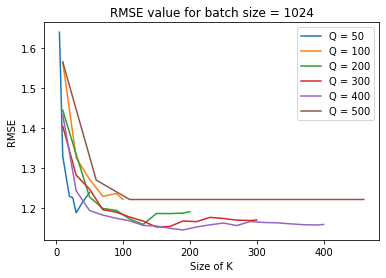

In [3]:
# plot directly with K and Q values
import matplotlib.pyplot as plt
plt.figure()
fig, ax = plt.subplots() 
ax.plot([5,10,20,25,30,40,50],b1024_q50, label = "Q = 50")
ax.plot([10,30,50,70,90,100],b1024_q100, label = "Q = 100")
ax.plot([10,30,50,70,90,110,130,150,170,190,200],b1024_q200, label = "Q = 200")
ax.plot([10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,300],b1024_q300, label = "Q = 300")
ax.plot([10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,310,330,350,370,390,400],b1024_q400, label = "Q = 400")
ax.plot([10,60,110,250,290,340,460],b_q500, label = "Q = 500")
plt.xlabel("Size of K")
plt.ylabel("RMSE")
plt.title("RMSE value for batch size = 1024")
plt.legend()


<Figure size 432x288 with 0 Axes>

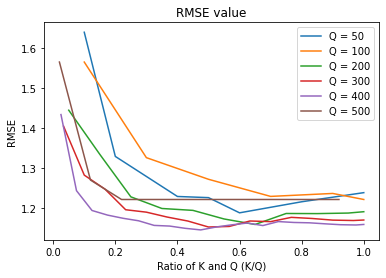

In [4]:
# calculate the ratio of K/Q for better interpretation

def ratio_func(rmselist,num):
  ratio = []
  for i in rmselist:  
    ratio.append(i/num)
  return ratio  

ratio_50 = ratio_func([5,10,20,25,30,40,50],50)
ratio_100 = ratio_func([10,30,50,70,90,100],100)
ratio_200 = ratio_func([10,30,50,70,90,110,130,150,170,190,200],200)
ratio_300 = ratio_func([10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,300],300)
ratio_400 = ratio_func([10,30,50,70,90,110,130,150,170,190,210,230,250,270,290,310,330,350,370,390,400],400)
ratio_500 = ratio_func([10,60,110,250,290,340,460],500)

import matplotlib.pyplot as plt
plt.figure()
fig, ax = plt.subplots() 
ax.plot(ratio_50,b1024_q50, label = "Q = 50")
ax.plot(ratio_100,b1024_q100, label = "Q = 100")
ax.plot(ratio_200,b1024_q200, label = "Q = 200")
ax.plot(ratio_300,b1024_q300, label = "Q = 300")
ax.plot(ratio_400,b1024_q400, label = "Q = 400")
ax.plot(ratio_500,b_q500, label = "Q = 500")
plt.xlabel("Ratio of K and Q (K/Q)")
plt.ylabel("RMSE")
plt.title("RMSE value")
plt.legend()
